In [39]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
from os.path import join as oj
import numpy as np
from copy import deepcopy
plt.style.use('dark_background')
import data
from matplotlib_venn import venn3, venn2
import pickle as pkl
import viz
from util.style import *
from util import analyze_helper, train
from sklearn import decomposition
from sklearn.calibration import calibration_curve
from sklearn import metrics
import config
import pandas as pd
from tqdm import tqdm
outcome_def = 'y_consec_thresh'
out_dir = oj('/scratch/users/vision/abc', 'may7_1') # mar7_2 is 0.95, mar8_1 is 0.96
results = analyze_helper.load_results(out_dir)

# get data
df = data.get_data()
n = df.shape[0]
df_cv = df[df.valid == 1] # exclude test cells, short/long tracks, hotspots
X, y, norms = analyze_helper.normalize(df_cv, outcome_def)

# select model
r = results
r = r.sort_values('accuracy', ascending=False)
idx = np.array(r.index)
accs = np.array(r.accuracy)
# model_name = idx[0]
model_name = 'mlp2_17_select_lasso=7_ros=1_h=0_cal=True'
print('using model', model_name)
for i in range(5):
    print(f'\t{accs[i]:.3f}', idx[i])
    

# load model + preds
d_full_cv, idxs_cv = analyze_helper.get_data_over_folds(model_name, out_dir, df_cv.cell_num, X, y)
y_full_cv = df_cv[outcome_def].iloc[idxs_cv].values.astype(np.int)
preds_cv = d_full_cv[model_name].values
preds_proba_cv = d_full_cv[model_name + '_proba'].values

results_individual = pkl.load(open(oj(out_dir, f'{model_name}.pkl'), 'rb'))
assert np.sum(idxs_cv == np.arange(idxs_cv.size)) == idxs_cv.size, \
       'points not in same order'
assert np.mean(preds_cv==y_full_cv) == np.average(results_individual['cv']['accuracy'], 
                                               weights=results_individual['num_pts_by_fold_cv']), \
        'did not properly load model/data'
tp, tn, fp, fn = analyze_helper.calc_errs(preds_cv, y_full_cv)
print('succesfully loaded!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
using model mlp2_17_select_lasso=7_ros=1_h=0_cal=True
	0.760 svm_17_select_lasso=9_ros=1.2_h=1_cal=True
	0.760 svm_17_select_lasso=9_ros=1_h=1_cal=True
	0.759 mlp2_17_select_lasso=9_ros=1_h=1_cal=True
	0.758 mlp2_17_select_lasso=15_ros=1_h=0_cal=True
	0.757 mlp2_17_select_lasso=9_ros=1_h=0_cal=True
succesfully loaded!


# lower res data

**data at lower res**

In [ ]:
accs = []
DOWNSAMPLE_list = range(1, 21)
for DOWNSAMPLE in tqdm(DOWNSAMPLE_list):

    # downsample
    df_cv = deepcopy(df[df.valid == 1]) # exclude test cells, short/long tracks, hotspots
    df_cv['X'] = [x[::DOWNSAMPLE] for x in df_cv.X]
    df_cv['X_extended'] = [x[::DOWNSAMPLE] for x in df_cv.X_extended]
    df_cv['lifetime'] = [len(x) for x in df_cv.X]
    df_cv = data.add_features(df_cv)


    # get data
    X, y, norms = analyze_helper.normalize(df_cv, outcome_def)
    d_full_cv, idxs_cv = analyze_helper.get_data_over_folds(model_name, out_dir, df_cv.cell_num, X, y)
    y_full_cv = df_cv[outcome_def].iloc[idxs_cv].values.astype(np.int)
    preds = d_full_cv[model_name].values
    preds_proba = d_full_cv[model_name + '_proba'].values
    acc = np.mean(preds==y_full_cv)
    accs.append(acc)
#     print(f'downsampling rate {DOWNSAMPLE} acc {acc.round(3)}')

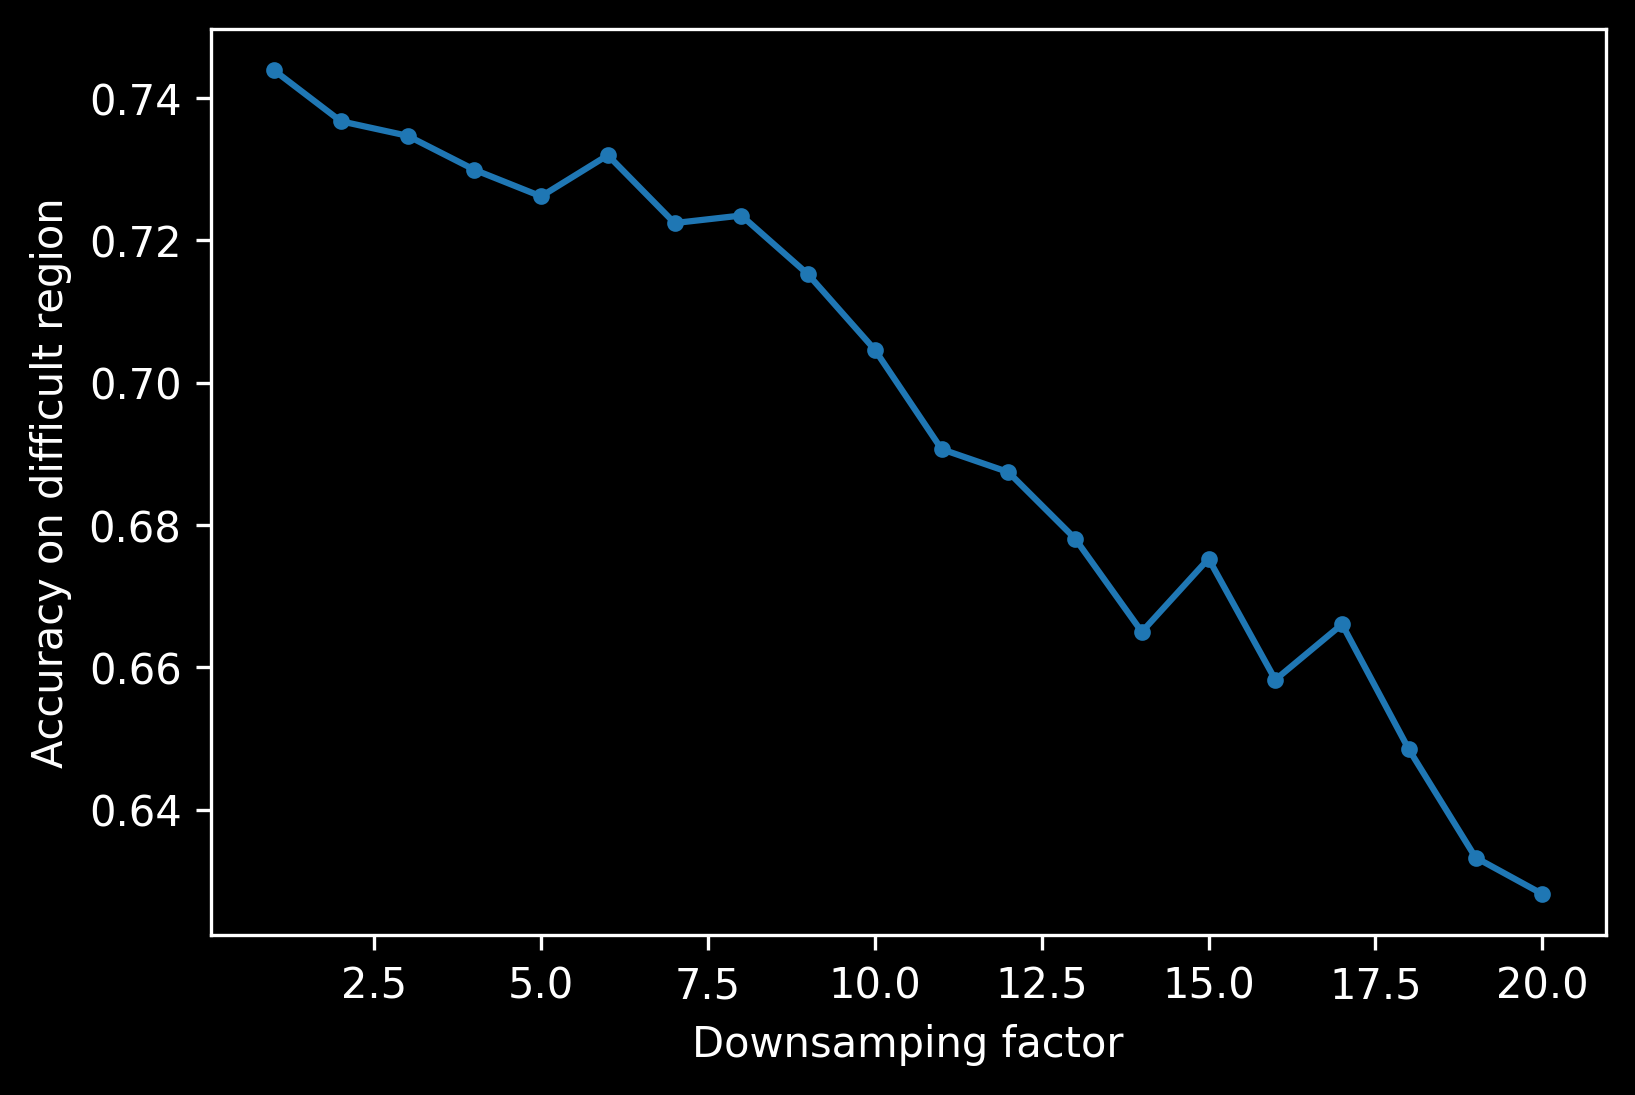

In [19]:
plt.figure(dpi=300)
plt.plot(DOWNSAMPLE_list, accs, '.-', color=cb)
plt.xlabel('Downsamping factor')
plt.ylabel('Accuracy on difficult region')
plt.savefig('downampling.pdf')
plt.show()

In [ ]:
track_num = 3
ex = deepcopy(df[df.valid == 1]).iloc[track_num]
# print(ex)
viz.plot_example(ex)
plt.plot(np.arange(len(ex.X))[::3], ex.X[::3], 'o', color='w', alpha=0.5)
plt.show()

# look at test data

In [20]:
# dsets: clath_aux, clath_aux_no_a7d2
df_new = data.get_data(dset='clath_aux_no_a7d2', use_processed=True,
                   use_processed_dicts=True, outcome_def=outcome_def,
                   previous_meta_file='processed/metadata_orig.pkl')

In [65]:
CELLS_TRAIN = config.DSETS['orig']['train']
df_train = df[df.cell_num.isin(CELLS_TRAIN)]
X_train = df_train[data.get_feature_names(df_train)]
X_mean_train = X_train.mean()
X_std_train = X_train.std()

CELLS_TEST = config.DSETS['orig']['test']
df_test = df[df.cell_num.isin(CELLS_TEST)]
X_test = df_test[data.get_feature_names(df_test)]
X_test = (X_test - X_mean_train) / X_std_train
y_test = df_test[outcome_def].values


# get model
m0 = results_individual['imps']['model'][0]
feat_names_selected = results_individual['feat_names_selected']
preds_test = m0.predict(X_test[feat_names_selected]) 
preds_proba_test = m0.predict_proba(X_test[feat_names_selected]) [:, 1]


dsets = ['validation', 'test'] #, 'new']
ys_list = [y_full_cv, y_test] #, y_new]
preds_list = [preds_cv, preds_test] #, preds_new]
preds_proba_list = [preds_proba_cv, preds_proba_test] #, preds_proba_new]

# loop over new datasets
dset_names = ['clath_aux', 'orig_gak', 'clath_aux_no_a7d2', 'clath_aux_a8', 'clath_pi4p_notreatment']
for dset_name in tqdm(dset_names):
    df_new = data.get_data(dset=dset_name, use_processed=True,
                           use_processed_dicts=True, outcome_def=outcome_def,
                           previous_meta_file='processed/metadata_orig.pkl')
    df_new = df_new[df_new['valid']] # exclude test cells, short/long tracks, hotspots
    X_new = df_new[data.get_feature_names(df_new)]
    X_new = (X_new - X_mean_train) / X_std_train
    y_new = df_new[outcome_def].values
    preds_new = m0.predict(X_new[feat_names_selected]) 
    preds_proba_new = m0.predict_proba(X_new[feat_names_selected])[:, 1]

    dsets.append(dset_name)
    ys_list.append(deepcopy(y_new))
    preds_list.append(deepcopy(preds_new))
    preds_proba_list.append(deepcopy(preds_proba_new))

100%|██████████| 5/5 [00:03<00:00,  1.24it/s]


In [67]:
def roundd(x):
    try:
        return x.round(2)
    except:
        return [y.round(2) for y in x]
    
def mean_diff(df, k, preds):
    return np.mean(df[k][preds==1] - df[k][preds==0])

r_long = {}
n = len(dsets)
for s in train.scorers:
    if s == 'roc_auc':
        r_long[s] = [roundd(metrics.roc_auc_score(ys_list[i],
                                                  preds_proba_list[i])) for i in range(n)]
    elif 'curve' not in s and 'acc' in s:
        r_long[s] = [roundd(train.scorers[s](ys_list[i], preds_list[i])) for i in range(n)]        

'''
for k in ['X_max']:
    r_long[k] = [mean_diff(df_cv, k, preds_cv),
                 mean_diff(y_test, k, preds_test),
                 mean_diff(y_new, k, preds_new)]
'''

"\nfor k in ['X_max']:\n    r_long[k] = [mean_diff(df_cv, k, preds_cv),\n                 mean_diff(y_test, k, preds_test),\n                 mean_diff(y_new, k, preds_new)]\n"

In [68]:
r_long

{'balanced_accuracy': [0.74, 0.76, 0.62, 0.62, 0.61, 0.56, 0.73],
 'accuracy': [0.74, 0.65, 0.7, 0.69, 0.63, 0.48, 0.83],
 'roc_auc': [0.81, 0.87, 0.7, 0.78, 0.77, 0.71, 0.86]}

In [69]:
r = pd.DataFrame.from_dict(r_long).transpose()
r.columns = dsets
r

,validation,test,clath_aux,orig_gak,clath_aux_no_a7d2,clath_aux_a8,clath_pi4p_notreatment
balanced_accuracy,0.74,0.76,0.62,0.62,0.61,0.56,0.73
accuracy,0.74,0.65,0.70,0.69,0.63,0.48,0.83
roc_auc,0.81,0.87,0.70,0.78,0.77,0.71,0.86


In [55]:
print(r.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  validation &  test &  clath\_aux &  orig\_gak &  clath\_aux\_no\_a7d2 &  clath\_aux\_a8 &  clath\_pi4p\_notreatment \\
\midrule
balanced\_accuracy &        0.74 &  0.76 &       0.69 &      0.77 &               0.75 &          0.73 &                    0.73 \\
accuracy          &        0.74 &  0.65 &       0.77 &      0.75 &               0.75 &          0.65 &                    0.69 \\
precision         &        0.74 &  0.39 &       0.61 &      0.54 &               0.42 &          0.34 &                    0.88 \\
recall            &        0.77 &  0.94 &       0.49 &      0.83 &               0.74 &          0.87 &                    0.64 \\
f1                &        0.75 &  0.55 &       0.54 &      0.66 &               0.53 &          0.48 &                    0.74 \\
roc\_auc           &        0.81 &  0.87 &       0.77 &      0.86 &               0.82 &          0.83 &                    0.80 \\
\bottomrule
\end{tabular}



In [ ]:
viz.plot_confusion_matrix(y_test, preds, 
                          classes=np.array(['aux-', 'aux+']), normalize=False)

In [ ]:
for s in train.scorers:
    print(s, f'train: {roundd(train.scorers[s](y_full_cv, preds_cv))}\ttest: {roundd(train.scorers[s](y_new, preds_test))}')    